In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
from scipy.signal import argrelextrema
from scipy import signal

In [2]:
contact = pd.read_csv("Contact.txt")

In [3]:
contact.head()

,20:37:41:030,519
0,20:37:41:070,507
1,20:37:41:110,501
2,20:37:41:150,501
3,20:37:41:190,504
4,20:37:41:230,508


In [4]:
geom = pd.read_csv("geom.txt",names=['x','y','z'],header=None,sep=' ')

In [5]:
geom.head()

,x,y,z
0,20.282408,13.224313,84.636943
1,53.698406,67.169669,135.402828
2,53.553210,67.119487,135.558500
3,52.444081,65.841050,133.247966
4,53.835639,67.188929,135.496609


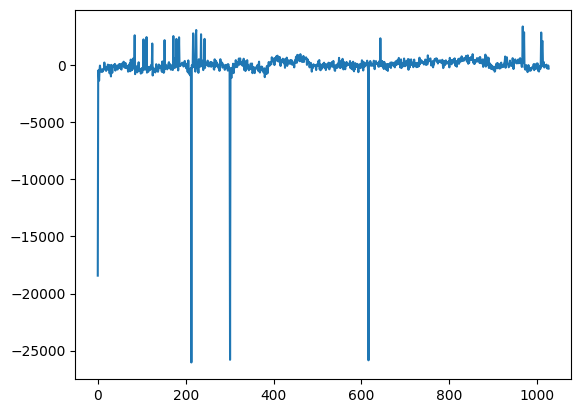

In [6]:
sig = geom['x']**2+geom['y']**2+geom['z']**2
plt.plot(sig-np.mean(sig))

In [7]:
sig

0        7749.670723
1       25729.209072
2       25749.078562
3       24840.446097
4       25771.959175
            ...     
1022    25930.767331
1023    25926.188815
1024    25914.373337
1025    26170.415591
1026    25906.417066
Length: 1027, dtype: float64

### **Get spectras**

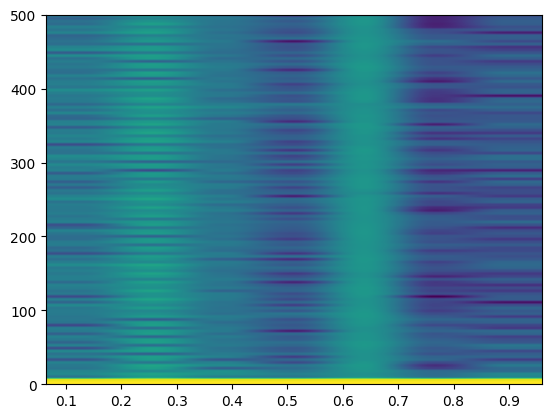

In [8]:
samplingFrequency = 1000
spectrum, freqs, t, im = plt.specgram(sig, Fs=samplingFrequency)

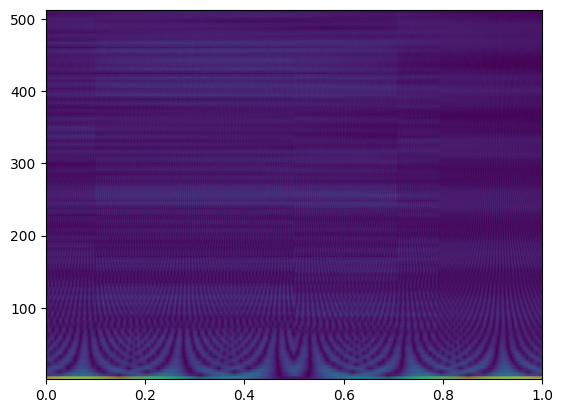

In [9]:
def GaborWavelet(points, width):
    omega = 1 / width
    Gabor_coef = 1
    t = np.arange(-points/2, points/2)
    return 0.325*np.sqrt(omega)*np.exp(-0.5*Gabor_coef*(t*omega*0.187)**2 + 1j * omega*t)

t, dt = np.linspace(0, 1, 1027, retstep=True)
fs = 1/dt
w=1000.


freq = np.linspace(1, fs/2, 100)
widths = w*fs / (2*freq*np.pi)

cwtm = signal.cwt(sig, signal.morlet2, widths, w=w)
plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
plt.show()

### **Algorithm 1 Rough estimate of heart rate frequency in the i-th spectrogram column**

In [10]:
np.shape(cwtm)

(100, 1027)

In [11]:
np.shape(freq)

(100,)

In [12]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def estimation_hrf(i):
  s = cwtm[:,i]
  # i-th column in spectrogram
  t_start = 0.5 * i 
  # start time of the i-th sliding window with stride 0.5 s
  signal_duration=np.size(sig)
  test_len = min(10, (signal_duration - t_start))
  x = sig[int(t_start):int(t_start+test_len)]
  # part of the signal between t_start and t_start + test_len seconds
  fmax = freq[np.argmax(s)]
  # frequency corresponding to the maximum value of s
  if fmax > 2:
    threshold = 2.5
  else: 
    if fmax < 1:
      threshold = 1.5
    else:
      threshold = 2
  xsm = butter_bandpass_filter(x, 0.1, threshold, 1/dt, order=6)
 
  test = butter_bandpass_filter(signal.unit_impulse(100, 'mid'), 0.1, threshold, 5000, order=6)

  signalAmplitude = np.sin(xsm)
  # plt.plot(xsm)
  plt.phase_spectrum(test, color ='green')
  print(xsm)
  #  bandpass filtration of x with cutoff frequencies 0.1 and threshold
  n_zero_cross = np.size(np.where(np.diff(np.sign(xsm)))[0])
  # number of times xsm crosses the zero level
  n_loc_max = len(argrelextrema(xsm, np.greater))
  # number of local maxima in xsm
  upper_estimate = 1/(test_len * n_loc_max)
  lower_estimate = 1/(test_len * 0.5 * np.max(n_zero_cross, 1))
  estimate = 0.5 * (lower_estimate + upper_estimate)
  F = np.argpartition(s, -3)[-3:]
  # frequencies corresponding to 3 highest peaks in s
  fhr = np.argmin(s[1:] - estimate)
  # arg min f∈F | f − estimate|
  return fhr

[1.18653742e-09 1.81103535e-08 1.35546425e-07 6.72378217e-07
 2.51853516e-06 7.68217173e-06 2.00519743e-05 4.63655240e-05
 9.73723158e-05 1.89179015e-04]


AxisError: axis 1 is out of bounds for array of dimension 0

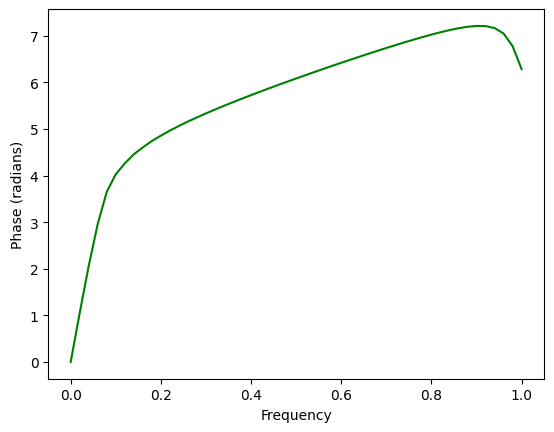

In [13]:
lst=[]
for i in range(len(cwtm)):
  lst.append(estimation_hrf(i))

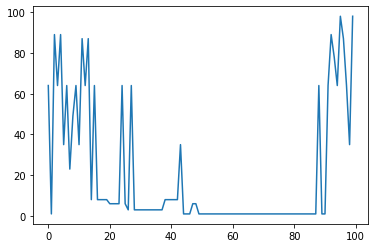

In [122]:
plt.plot(lst)